# **Project Part 02 - Rental Price Estimator**


<font size="3"> The goal of the Rent Value Estimator is to provide homeowners, real estate investors, and rental management companies with an estimation of the monthly rental income a property could generate, based on a percentage of the property’s value (here assumed to be 0.4% of the house’s sale value as defined in the Class with the GenG Team). This estimator helps answer critical business questions such as:

- Should I rent or sell my property?
- How much monthly rental income can I expect from my house?
- Is it worth managing this property for rental income?
</font>

### Important Liabraries for this project

In [247]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

### Utility Functions

In [248]:
# Define a function for calculating minMaxScaling:
def min_max_scaling(df, cols):
    for column in cols:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    
    return df

# Define a function for randomly splitting data into train and test:
def train_test_random_spliter(df, train_size, seed_value=42):

    # random value for split
    np.random.seed(seed_value)
    shuffled_indices = np.random.permutation(len(df))

    # Define the split index
    split_index = int(train_size * len(shuffled_indices))

    # Create train and test sets by splitting the shuffled DataFrame
    df_train = df.iloc[shuffled_indices[:split_index]]
    df_test = df.iloc[shuffled_indices[split_index:]]

    return df_train, df_test


def evaluation_metrics(y_true, y_pred):
    """
    Computes evaluation metrics for our regression model:
    1. OLS (Ordinary Least Squares)
    2. R-squared
    3. MAPE (Mean Absolute Percentage Error)
    """
    
    N = len(y_true)

    # Ordinary Least Squares (OLS)
    ols = (1 / (2 * N)) * np.sum((y_true - y_pred) ** 2)
    
    # R-squared (Coefficient of Determination)
    r_squared = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        "OLS": round(float(ols), 4),
        "R-squared": round(float(r_squared), 4),
        "MAPE": round(float(mape), 4)
    }


### Data selection and preparation

**IMPORTANT**: The Value 0.004 is a requirement, it can be changed if needed.

In [249]:
# Import Cleaned Dataset (Clean UP already done in previous section)
cleaned_data = pd.read_csv("raw_house_data_cleaned.csv")

# Renaming "price" column
newColumns = {'price': "rental_price"}
cleaned_data.rename(columns=newColumns, inplace=True)

# Setting Monthly Renting Price according to 0.4% radio as discussed in GenG class:
cleaned_data["rental_price"] = cleaned_data["rental_price"] * 0.004

In [250]:
cleaned_data.columns[:18]

Index(['Unnamed: 0', 'mls', 'rental_price', 'zipcode', 'longitude', 'latitude',
       'lot_acres', 'taxes', 'year_built', 'bedrooms', 'bathrooms', 'sqrt_ft',
       'garage', 'kitchen_features', 'fireplaces', 'hoa', 'num_kit_features',
       'bedroom_bathroom_ratio'],
      dtype='object')

In [251]:
cleaned_data.head()

,Unnamed: 0,mls,rental_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,...,floor_covering_Other: Tile-Other,floor_covering_Other: Travertine,floor_covering_Other: travertine,floor_covering_Wood,"floor_covering_Wood, Other","floor_covering_Wood, Other: Lime Stone","floor_covering_Wood, Other: Porcelain tile","floor_covering_Wood, Other: Travertine","floor_covering_Wood, Other: Travertine/Marble","floor_covering_Wood, Other: porcelain tile"
0,4,21306357,13645.8,85750,-110.813768,32.285162,3.21,15393.00,1995,4,...,False,False,False,False,False,False,False,False,False,False
1,5,21528016,13000.0,85718,-110.910593,32.339090,1.67,27802.84,1999,3,...,False,False,False,False,False,False,False,False,False,False
2,13,21625369,8800.0,85658,-111.049837,32.483063,1.82,5198.58,2015,4,...,False,False,False,False,False,False,False,False,False,False
3,14,21534099,12000.0,85739,-110.883068,32.508778,0.00,29669.00,2008,3,...,False,False,False,False,False,False,False,False,False,False
4,15,21225585,10400.0,85739,-110.883252,32.507699,0.00,18044.00,2008,3,...,False,False,False,False,False,False,False,False,False,False


In [252]:
# New feature engineering:
cleaned_data["year_sqrt"] = cleaned_data["year_built"] * cleaned_data["sqrt_ft"]

# Get the current year
current_year = datetime.now().year

# Create a new column 'house_age' that calculates the age of the house
cleaned_data['house_age'] = current_year - cleaned_data['year_built']
cleaned_data['inverse_house_age'] = 1 / cleaned_data['house_age'].replace(0, 1)

# Mean house price per zipcode
zipcode_means = cleaned_data.groupby('zipcode')['rental_price'].mean()
cleaned_data['zipcode_mean_price'] = cleaned_data['zipcode'].map(zipcode_means)


# Feature selections:
selected_columns = ['rental_price', "sqrt_ft", "year_sqrt" , "zipcode_mean_price" , "lot_acres", "latitude" , "longitude" , 'taxes', "inverse_house_age" , "bedrooms", "bathrooms" ,"fireplaces", "garage"]
rentalHouse_df = cleaned_data[selected_columns]

rentalHouse_df.describe()

,rental_price,sqrt_ft,year_sqrt,zipcode_mean_price,lot_acres,latitude,longitude,taxes,inverse_house_age,bedrooms,bathrooms,fireplaces,garage
count,4203.000000,4203.000000,4.203000e+03,4203.000000,4203.000000,4203.000000,4203.000000,4203.000000,4203.000000,4203.000000,4203.000000,4203.000000,4203.000000
mean,3029.628269,3596.675708,7.179826e+06,3029.628269,1.052929,32.331400,-110.920075,6620.308330,0.049132,3.857959,3.731858,1.802522,2.793719
std,1088.352055,837.733410,1.672207e+06,308.984537,0.781567,0.132222,0.091211,3204.701471,0.032944,0.817206,0.918995,1.064338,0.956721
min,676.000000,1690.000000,3.398590e+06,676.000000,0.000000,31.451945,-111.430863,0.000000,0.012195,2.000000,2.000000,0.000000,0.000000
25%,2336.000000,3038.000000,6.052112e+06,2773.326567,0.535000,32.291521,-110.978280,4782.975000,0.028571,3.000000,3.000000,1.000000,2.000000
50%,2696.000000,3476.000000,6.942766e+06,3119.858334,0.890000,32.322173,-110.923607,6138.000000,0.041667,4.000000,4.000000,2.000000,3.000000
75%,3300.000000,4020.000000,8.032987e+06,3195.821858,1.220000,32.404579,-110.862144,7887.255000,0.055556,4.000000,4.000000,2.000000,3.000000
max,13645.800000,7002.000000,1.395185e+07,3735.687654,3.360000,34.314889,-109.861617,30072.260000,0.200000,10.000000,10.000000,7.000000,30.000000


### Scaling

In [253]:
# Scaling using the MinMax
scaled_columns = ["sqrt_ft","taxes","lot_acres", "year_sqrt" , "latitude", "longitude", "zipcode_mean_price", 'bedrooms', 'bathrooms', "fireplaces", "garage"]
rentalHouse_df = min_max_scaling(rentalHouse_df, scaled_columns)
rentalHouse_df.head()

C:\Users\Younes Abaroudi\AppData\Local\Temp\ipykernel_17564\590987216.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
C:\Users\Younes Abaroudi\AppData\Local\Temp\ipykernel_17564\590987216.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
C:\Users\Younes Abaroudi\AppData\Local\Temp\ipykernel_17564\590987216.py:4: SettingWithCopyWarning

,rental_price,sqrt_ft,year_sqrt,zipcode_mean_price,lot_acres,latitude,longitude,taxes,inverse_house_age,bedrooms,bathrooms,fireplaces,garage
0,13645.8,0.885919,0.887065,0.798728,0.955357,0.291035,0.393243,0.511867,0.034483,0.250,0.500,0.714286,0.1
1,13000.0,0.969880,0.973971,0.823555,0.497024,0.309872,0.331541,0.924534,0.040000,0.125,0.250,0.714286,0.1
2,8800.0,0.778614,0.790353,1.000000,0.541667,0.360160,0.242808,0.172870,0.111111,0.250,0.500,0.428571,0.1
3,12000.0,0.264495,0.266853,0.733795,0.000000,0.369142,0.349082,0.986590,0.062500,0.125,0.125,0.428571,0.0
4,10400.0,0.264495,0.266853,0.733795,0.000000,0.368765,0.348964,0.600021,0.062500,0.125,0.125,0.428571,0.0


### Data split

In [254]:
# Split Data into train and test datasets (allocating 80% for Trainning):
df_train, df_test = train_test_random_spliter(rentalHouse_df, train_size=0.8)

# Separate the train and test datasets into features and predictor
X_train = df_train[selected_columns[1:]]
y_train = df_train['rental_price']

X_test = df_test[selected_columns[1:]]
y_test = df_test['rental_price']

# Now X_train, X_test, y_train, y_test contain the split data
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# Storing Metrics:
metrics_db = {}

X_train shape: (3362, 12), X_test shape: (841, 12)
y_train shape: (3362,), y_test shape: (841,)


### Applying Simple Linear Regression

In [255]:
import numpy as np

class SimpleLinearReg():

    def fit(self, X, y):

        self.y = y
        self.d = np.mean(X**2) - np.mean(X) ** 2
        
        # Compute the slope (w1) using the covariance of X and y
        self.w1 = (np.mean(X * y) - np.mean(X) * np.mean(y)) / self.d
        
        # Compute the intercept (w0)
        self.w0 = (np.mean(y) * np.mean(X**2) - np.mean(X) * np.mean(X * y)) / self.d

    def predict(self, X):

        # Calculate the predicted values using the linear equation
        y_hat = self.w1 * X + self.w0
        
        return y_hat


In [256]:
# Initialize the SimpleLinearReg class
slr = SimpleLinearReg()

# Select one feature for training
X_train_slr = X_train["sqrt_ft"]
X_test_slr = X_test["sqrt_ft"]

# Fit the model with the training data
slr.fit(X_train_slr, y_train)

# Make predictions on the test data
y_predicted_slr = slr.predict(X_test_slr)

# Evaluate the Simple Regression Model
metrics = evaluation_metrics(y_test, y_predicted_slr)
metrics_db["Simple Regression Model"] = metrics

# Print the metrics
print("Metrics for the Simple Regression Model")
print(metrics)

Metrics for the Simple Regression Model
{'OLS': 456962.3588, 'R-squared': 0.2669, 'MAPE': 18.3741}


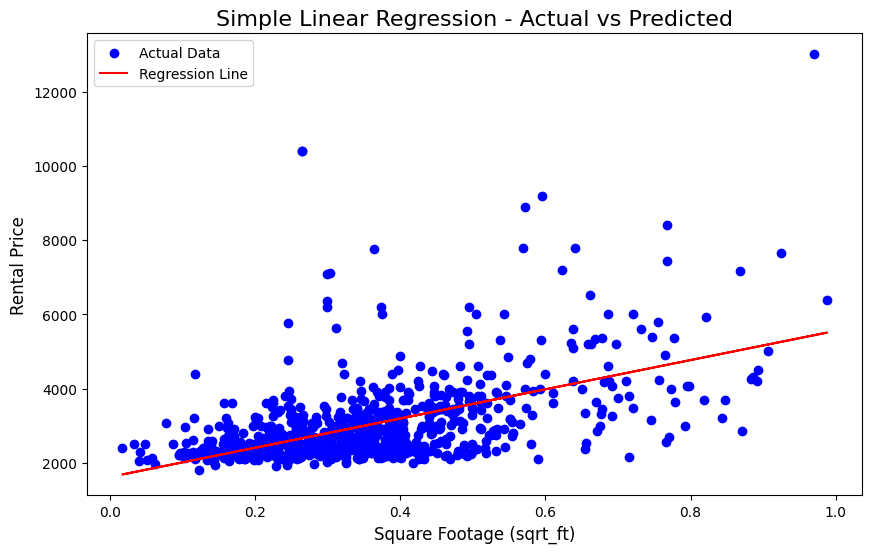

In [257]:
# Simple Linear Regression - Actual vs Predicted
plt.figure(figsize=(10,6))
plt.scatter(X_test_slr, y_test, color='blue', label='Actual Data')
plt.plot(X_test_slr, y_predicted_slr, color='red', label='Regression Line')
plt.title('Simple Linear Regression - Actual vs Predicted', fontsize=16)
plt.xlabel('Square Footage (sqrt_ft)', fontsize=12)
plt.ylabel('Rental Price', fontsize=12)
plt.legend()
plt.show()

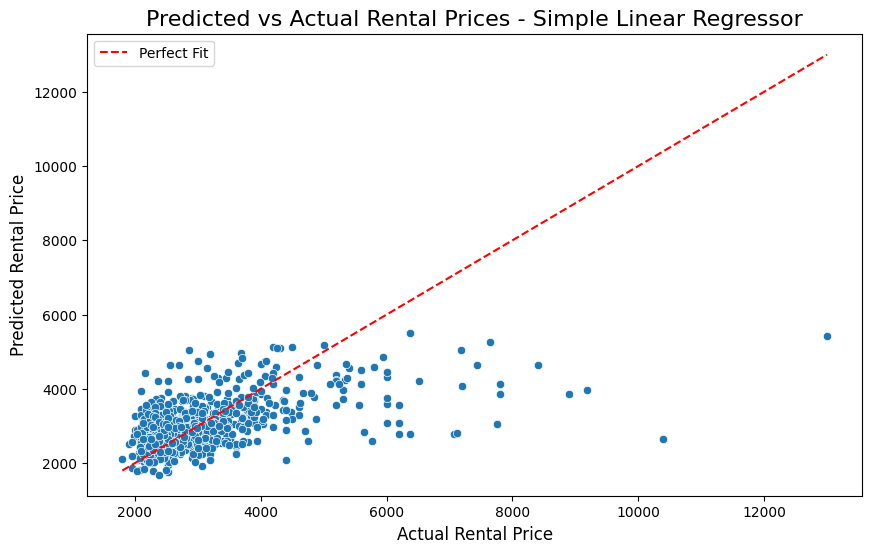

In [258]:
# Predicted vs Actual Rental Prices - Simple Linear Regressor
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_predicted_slr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Fit')
plt.title('Predicted vs Actual Rental Prices - Simple Linear Regressor', fontsize=16)
plt.xlabel('Actual Rental Price', fontsize=12)
plt.ylabel('Predicted Rental Price', fontsize=12)
plt.legend()
plt.show()


### Fast Simple Linear Regression using Linalg.Solve

In [259]:
class FastSLR():

    def fit(self, X, y):

        # Solve for the weight vector W using the normal equation
        self.W = np.linalg.solve(X.T @ X, X.T @ y)
    
    def predict(self, X):

        return np.matmul(X, self.W)

In [260]:
# Fit the Fast Simple Linear Regression Model
fast_slr = FastSLR()
fast_slr.fit(X_train, y_train)

# Predict the Rental Price:
y_predicted_fast_slr = fast_slr.predict(X_test)

# Evaluate the Simple Regression Model
metrics = evaluation_metrics(y_test, y_predicted_fast_slr)
metrics_db["Fast Simple Linear Regression"] = metrics

# Print the metrics
print("Metrics for the Fast Simple Linear Regression")
print(metrics)

Metrics for the Fast Simple Linear Regression
{'OLS': 293414.5273, 'R-squared': 0.5293, 'MAPE': 15.0944}


### Multi Variate Linear Regressor

In [261]:
import numpy as np
import matplotlib.pyplot as plt

class MVLinearRegression:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None

    def fit(self, X, y):

        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        bias = 0

        # Stochastic Gradient Descent
        for _ in range(self.epochs):
            for i in range(n_samples):
                linear_model = np.dot(X[i], self.weights) + bias
                error = linear_model - y[i]

                # Update the weights and bias
                self.weights -= self.learning_rate * error * X[i]
                bias -= self.learning_rate * error

        self.bias = bias

    def predict(self, X):

        return np.dot(X, self.weights) + self.bias

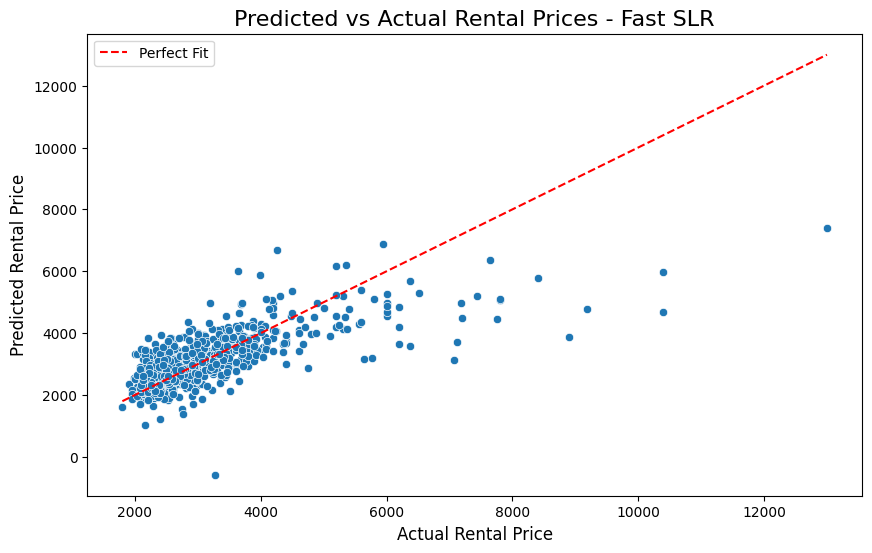

In [262]:
# Predicted vs Actual Rental Prices - Fast SLR
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_predicted_fast_slr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Fit')
plt.title('Predicted vs Actual Rental Prices - Fast SLR', fontsize=16)
plt.xlabel('Actual Rental Price', fontsize=12)
plt.ylabel('Predicted Rental Price', fontsize=12)
plt.legend()
plt.show()

In [263]:
# Instanciate a Multi Variate Linear Regression object
mv_linear_regression = MVLinearRegression(learning_rate=0.01, epochs=1000)

# Fit the MV linear Regression Model to the training dataset:
mv_linear_regression.fit(X_train.values, y_train.values)

# Predict the Rental Price
y_predicted_mv_linear_regression = mv_linear_regression.predict(X_test)

# Evaluate the Multi Variate Linear Regression Model
metrics = evaluation_metrics(y_test, y_predicted_mv_linear_regression)
metrics_db["MV Linear Regression"] = metrics

# Print the metrics
print("Metrics for the Multi Variate Linear Regression Model")
print(metrics)

Metrics for the Multi Variate Linear Regression Model
{'OLS': 290177.2205, 'R-squared': 0.5345, 'MAPE': 14.7751}


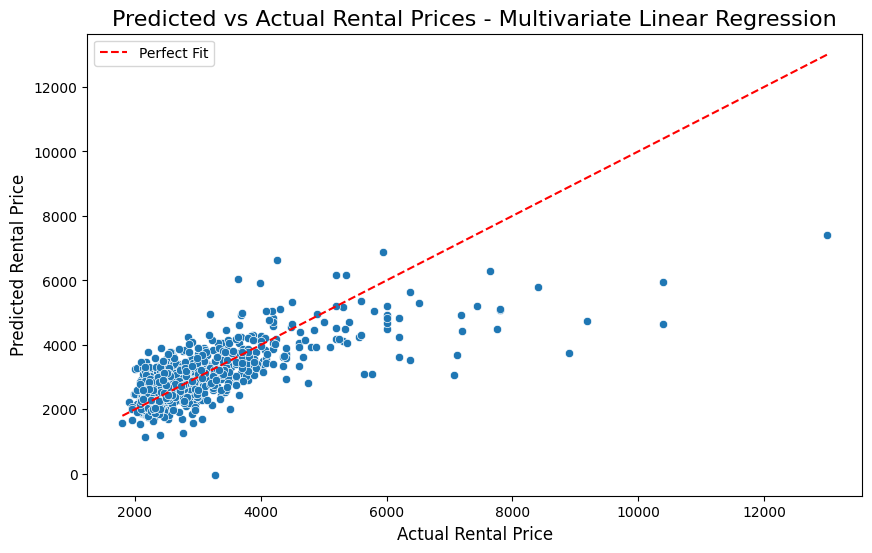

In [264]:
# Predicted vs Actual Rental Prices - Multivariate Linear Regression
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_predicted_mv_linear_regression)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Fit')
plt.title('Predicted vs Actual Rental Prices - Multivariate Linear Regression', fontsize=16)
plt.xlabel('Actual Rental Price', fontsize=12)
plt.ylabel('Predicted Rental Price', fontsize=12)
plt.legend()
plt.show()

### Applying KNN Regressor 

In [265]:
import numpy as np

class KNNRegressor:

    def __init__(self, k=5):
        self.k = k  # Number of neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):

        y_pred = [] 
        
        for x_test in X_test:
            # Calculate Euclidean distances between x_test and all points in X_train
            distances = np.sqrt(np.sum((self.X_train - x_test) ** 2, axis=1))
            
            # Find the indices of the k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]
            
            # Get the target values of the k nearest neighbors
            k_nearest_targets = self.y_train[k_indices]
            
            # Predict the target as the mean of the nearest neighbors' targets
            y_pred.append(np.mean(k_nearest_targets))
        
        return np.array(y_pred)

In [266]:
# Initialize and train the KNN model with k=5
knn_regressor = KNNRegressor(k=5)
knn_regressor.fit(X_train.values, y_train.values)

# Predict on the test set
y_pred_knn = knn_regressor.predict(X_test.values)

test_knn = [] # list for storing knn metrics
for k in range(5, 15):
    knn_regressor = KNNRegressor(k * 1)
    knn_regressor.fit(X_train.values, y_train.values)
    y_pred_knn = knn_regressor.predict(X_test.values)
    if k == 5:
        y_pred_knn_5 = y_pred_knn

    metrics = evaluation_metrics(y_test, y_pred_knn)
    knn_name = "KNNRegressor K = " + str(k)
    metrics_db[knn_name] = metrics
    
    # test_knn.append({k: metric})
    print(f"Metrics for k = {k}: {metrics}")

Metrics for k = 5: {'OLS': 210760.4493, 'R-squared': 0.6619, 'MAPE': 12.8922}
Metrics for k = 6: {'OLS': 224815.6078, 'R-squared': 0.6393, 'MAPE': 13.1693}
Metrics for k = 7: {'OLS': 222586.6475, 'R-squared': 0.6429, 'MAPE': 13.0951}
Metrics for k = 8: {'OLS': 224984.0225, 'R-squared': 0.6391, 'MAPE': 13.1294}
Metrics for k = 9: {'OLS': 227828.5027, 'R-squared': 0.6345, 'MAPE': 13.2607}
Metrics for k = 10: {'OLS': 232671.6924, 'R-squared': 0.6267, 'MAPE': 13.2637}
Metrics for k = 11: {'OLS': 235211.4939, 'R-squared': 0.6227, 'MAPE': 13.154}
Metrics for k = 12: {'OLS': 241002.4303, 'R-squared': 0.6134, 'MAPE': 13.2364}
Metrics for k = 13: {'OLS': 243355.7022, 'R-squared': 0.6096, 'MAPE': 13.2447}
Metrics for k = 14: {'OLS': 248636.4356, 'R-squared': 0.6011, 'MAPE': 13.3275}


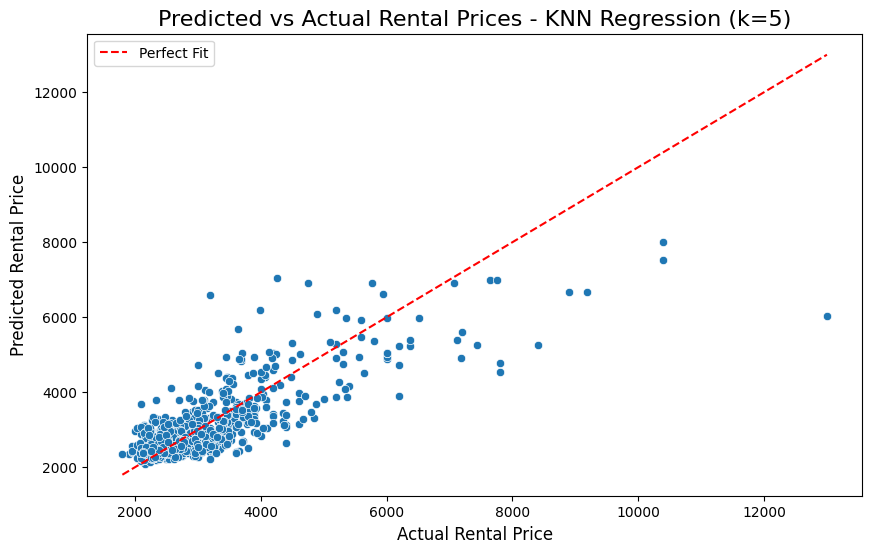

In [267]:
# Predicted vs Actual Rental Prices - KNN Regression (k=5)
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred_knn_5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Fit')
plt.title('Predicted vs Actual Rental Prices - KNN Regression (k=5)', fontsize=16)
plt.xlabel('Actual Rental Price', fontsize=12)
plt.ylabel('Predicted Rental Price', fontsize=12)
plt.legend()
plt.show()

### COMPARAISON BETWEEN MODELS

In [268]:
for key, value in metrics_db.items():
    print(key, value)


Simple Regression Model {'OLS': 456962.3588, 'R-squared': 0.2669, 'MAPE': 18.3741}
Fast Simple Linear Regression {'OLS': 293414.5273, 'R-squared': 0.5293, 'MAPE': 15.0944}
MV Linear Regression {'OLS': 290177.2205, 'R-squared': 0.5345, 'MAPE': 14.7751}
KNNRegressor K = 5 {'OLS': 210760.4493, 'R-squared': 0.6619, 'MAPE': 12.8922}
KNNRegressor K = 6 {'OLS': 224815.6078, 'R-squared': 0.6393, 'MAPE': 13.1693}
KNNRegressor K = 7 {'OLS': 222586.6475, 'R-squared': 0.6429, 'MAPE': 13.0951}
KNNRegressor K = 8 {'OLS': 224984.0225, 'R-squared': 0.6391, 'MAPE': 13.1294}
KNNRegressor K = 9 {'OLS': 227828.5027, 'R-squared': 0.6345, 'MAPE': 13.2607}
KNNRegressor K = 10 {'OLS': 232671.6924, 'R-squared': 0.6267, 'MAPE': 13.2637}
KNNRegressor K = 11 {'OLS': 235211.4939, 'R-squared': 0.6227, 'MAPE': 13.154}
KNNRegressor K = 12 {'OLS': 241002.4303, 'R-squared': 0.6134, 'MAPE': 13.2364}
KNNRegressor K = 13 {'OLS': 243355.7022, 'R-squared': 0.6096, 'MAPE': 13.2447}
KNNRegressor K = 14 {'OLS': 248636.4356, 'R

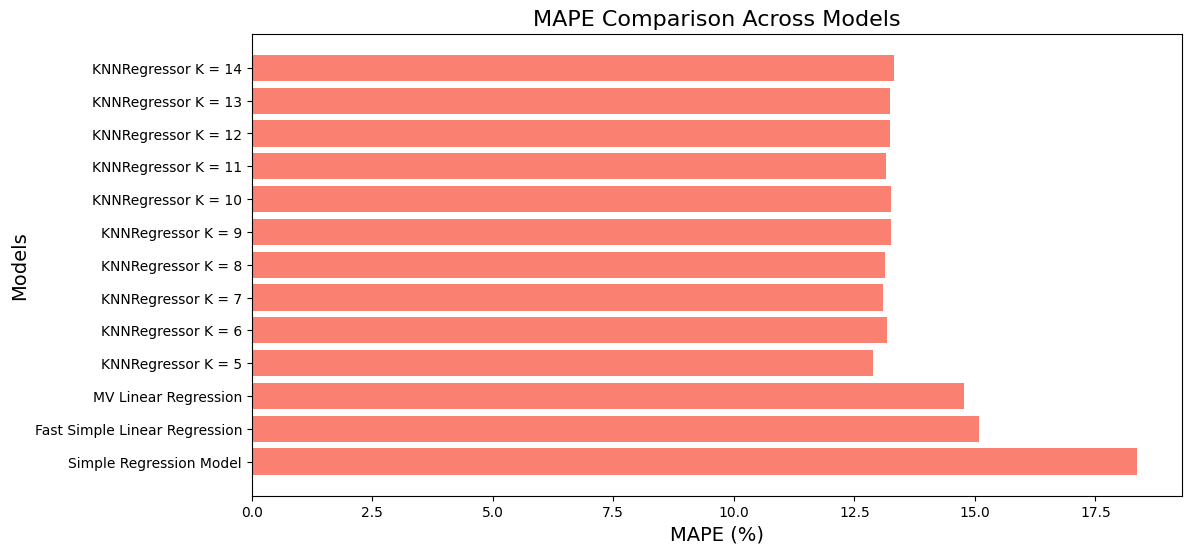

In [269]:
# Plot MAPE metric for different Models
models = [model for model in metrics_db.keys()]
mape_values = [model_value["MAPE"] for model_value in metrics_db.values()]
plt.figure(figsize=(12,6))
plt.barh(models, mape_values, color='salmon')
plt.title('MAPE Comparison Across Models', fontsize=16)
plt.xlabel('MAPE (%)', fontsize=14)
plt.ylabel('Models', fontsize=14)
plt.show()

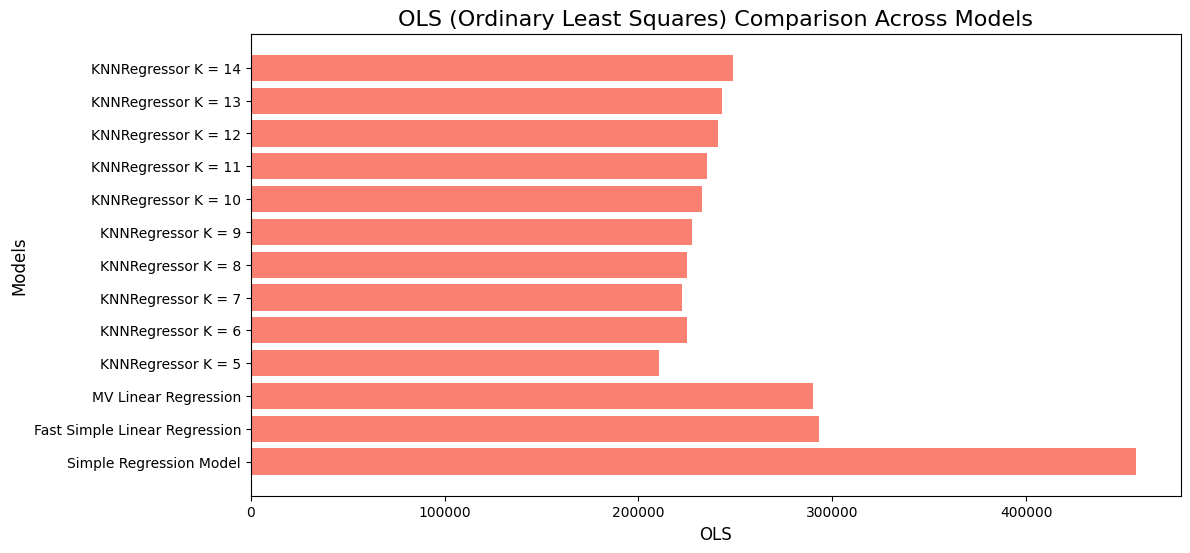

In [270]:
# Plot MAPE metric for different Models
models = [model for model in metrics_db.keys()]
mape_values = [model_value["OLS"] for model_value in metrics_db.values()]
plt.figure(figsize=(12,6))
plt.barh(models, mape_values, color='salmon')
plt.title('OLS (Ordinary Least Squares) Comparison Across Models', fontsize=16)
plt.xlabel('OLS', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.show()
